In [ ]:
#!pip install -r requirements.txt

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Concatenate, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import ffmpeg

In [2]:
# Constants
DATASET_PATH = r'C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cricket Dataset'
SEQUENCE_LENGTH = 30
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
FRAME_SAMPLE_INTERVAL = 2  # Process every 5th frame to speed up
CLASSES_LIST = ['start_frame', 'shot_frame', 'end_frame']
SHOT_CLASSES_LIST = ['cover', 'defense', 'flick', 'hook', 'lofted', 'pull']

In [3]:
# Load and Explore Dataset
def load_dataset(dataset_path):
    data = []
    for shot_type in os.listdir(dataset_path):
        shot_folder = os.path.join(dataset_path, shot_type)
        if os.path.isdir(shot_folder):
            for video_name in os.listdir(shot_folder):
                video_path = os.path.join(shot_folder, video_name)
                cap = cv2.VideoCapture(video_path)
                length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                data.append([video_name, shot_type, length, video_path])
                cap.release()
    df = pd.DataFrame(data, columns=['filename', 'shot_type', 'length', 'path'])
    return df

In [4]:
def plot_frames(df, dataset_path):
    for shot_type in df['shot_type'].unique():
        sample = df[df['shot_type'] == shot_type].iloc[0]
        video_path = os.path.join(dataset_path, sample['shot_type'], sample['filename'])
        cap = cv2.VideoCapture(video_path)
        frames = []
        
        # Extract three frames evenly spaced throughout the video
        for i in range(3):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * (sample['length'] // 3))
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
                frames.append(frame)
        cap.release()

        # Create a smaller plot for easier report inclusion
        fig, axes = plt.subplots(1, 3, figsize=(8, 4), dpi=100)
        for idx, frame in enumerate(frames):
            axes[idx].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'{shot_type} frame {idx}')
            axes[idx].axis('off')  # Turn off axis

        plt.tight_layout()
        plt.savefig(f'{shot_type}_frames.png', bbox_inches='tight')
        plt.show()

In [5]:
# Extract Pose Features using MediaPipe
mp_pose = mp.solutions.pose

In [6]:
def extract_pose_features(df):
    mp_pose = mp.solutions.pose
    pose_features = []

    for _, row in df.iterrows():
        video_path = row['path']
        cap = cv2.VideoCapture(video_path)
        pose_data = []
        frame_count = 0
        
        with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1

                # Sample frames to reduce processing time
                if frame_count % FRAME_SAMPLE_INTERVAL == 0:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = pose.process(frame_rgb)
                    
                    if results.pose_landmarks:
                        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
                        pose_data.append(landmarks)
                    else:
                        pose_data.append(np.zeros(33 * 3))

        cap.release()
        pose_features.append(pose_data)
    
    # Add pose_features to the DataFrame
    df['pose_features'] = pose_features
    return df

In [7]:
# Model Creation
def create_convlstm_model(classes_list):
    frames_input = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='frames_input')
    pose_input = Input(shape=(SEQUENCE_LENGTH, 33 * 3), name='pose_input')

    x = ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(frames_input)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                   recurrent_dropout=0.2, return_sequences=True)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)

    x = Flatten()(x)

    y = Flatten()(pose_input)

    combined = Concatenate()([x, y])

    output = Dense(len(classes_list), activation="softmax")(combined)

    model = Model(inputs=[frames_input, pose_input], outputs=output)

    model.summary()
    return model

In [8]:
# Train, Test, and Validate the Model
def train_model(df, classes_list):
    X_frames = []
    X_pose = []
    y = []

    for _, row in df.iterrows():
        cap = cv2.VideoCapture(row['path'])
        frames = []
        labels = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
            frames.append(frame)

            # Create labels: assuming start_frame is the first frame, shot_frame is middle frames, end_frame is the last frame
            if len(frames) <= SEQUENCE_LENGTH // 3:
                labels.append(0)  # start_frame
            elif len(frames) > SEQUENCE_LENGTH // 3 and len(frames) <= 2 * SEQUENCE_LENGTH // 3:
                labels.append(1)  # shot_frame
            else:
                labels.append(2)  # end_frame

        cap.release()

        for i in range(0, len(frames) - SEQUENCE_LENGTH, SEQUENCE_LENGTH):
            X_frames.append(frames[i:i+SEQUENCE_LENGTH])
            X_pose.append(row['pose_features'][i:i+SEQUENCE_LENGTH])
            y.append(labels[i:i+SEQUENCE_LENGTH])

    X_frames = np.array(X_frames)
    X_pose = np.array(X_pose)
    y = np.array(y)

    X_train_frames, X_test_frames, X_train_pose, X_test_pose, y_train, y_test = train_test_split(
        X_frames, X_pose, y, test_size=0.2, random_state=42
    )

    model = create_convlstm_model(classes_list)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        [X_train_frames, X_train_pose], y_train,
        validation_data=([X_test_frames, X_test_pose], y_test),
        epochs=20, batch_size=8
    )

    model.save(f'{classes_list[0]}_model.h5')

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()

    # Confusion Matrix and Classification Report
    y_pred = model.predict([X_test_frames, X_test_pose])
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test.flatten(), y_pred_classes.flatten())
    cr = classification_report(y_test.flatten(), y_pred_classes.flatten(), target_names=classes_list)
    print(cr)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_list)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig('confusion_matrix.png')
    plt.show()

    return model

In [9]:
# Use the Model for Inference on Full Match Video
def extract_and_classify_clips(model, video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    frames = []
    pose_data = []
    clip_index = 0

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame_rgb)
            if results.pose_landmarks:
                landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
                pose_data.append(landmarks)
            else:
                pose_data.append(np.zeros(33 * 3))

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
            frames.append(frame)

            if len(frames) == SEQUENCE_LENGTH:
                prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(pose_data, axis=0)])
                pred_class = np.argmax(prediction, axis=1)

                if pred_class[0] == 0:
                    label = 'start_frame'
                elif pred_class[0] == 1:
                    label = 'shot_frame'
                else:
                    label = 'end_frame'

                clip_dir = os.path.join(output_dir, label)
                os.makedirs(clip_dir, exist_ok=True)
                clip_path = os.path.join(clip_dir, f'clip_{clip_index}.avi')

                out = cv2.VideoWriter(clip_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (IMAGE_WIDTH, IMAGE_HEIGHT))
                for frame in frames:
                    out.write(frame)
                out.release()
                clip_index += 1

                frames = []
                pose_data = []

    cap.release()

In [10]:
# Shot Detection Model
def create_shot_detection_model(classes_list):
    return create_convlstm_model(classes_list)

In [11]:
def train_shot_detection_model(df):
    return train_model(df, SHOT_CLASSES_LIST)

In [12]:
# Classify Clips using Shot Detection Model
def classify_shots(model, input_dir, output_dir):
    for label in os.listdir(input_dir):
        label_dir = os.path.join(input_dir, label)
        if os.path.isdir(label_dir):
            for clip_name in os.listdir(label_dir):
                clip_path = os.path.join(label_dir, clip_name)
                cap = cv2.VideoCapture(clip_path)
                frames = []
                pose_data = []

                with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        results = pose.process(frame_rgb)
                        if results.pose_landmarks:
                            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
                            pose_data.append(landmarks)
                        else:
                            pose_data.append(np.zeros(33 * 3))

                        frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        frames.append(frame)

                        if len(frames) == SEQUENCE_LENGTH:
                            prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(pose_data, axis=0)])
                            pred_class = np.argmax(prediction, axis=1)

                            shot_label = SHOT_CLASSES_LIST[pred_class[0]]

                            shot_dir = os.path.join(output_dir, shot_label)
                            os.makedirs(shot_dir, exist_ok=True)
                            shot_path = os.path.join(shot_dir, f'{clip_name}')

                            out = cv2.VideoWriter(shot_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (IMAGE_WIDTH, IMAGE_HEIGHT))
                            for frame in frames:
                                out.write(frame)
                            out.release()

                            frames = []
                            pose_data = []

                cap.release()

In [13]:
# Combine Videos using FFmpeg
def combine_videos(input_dir, output_path):
    input_files = []
    for shot_label in os.listdir(input_dir):
        shot_dir = os.path.join(input_dir, shot_label)
        if os.path.isdir(shot_dir):
            for video_name in os.listdir(shot_dir):
                input_files.append(os.path.join(shot_dir, video_name))

    with open('input_videos.txt', 'w') as f:
        for file in input_files:
            f.write(f"file '{file}'\n")

    ffmpeg.input('input_videos.txt', format='concat', safe=0).output(output_path, c='copy').run()


In [14]:
df = load_dataset(DATASET_PATH)
# df.head()
# df['shot_type'].unique()
df[df['length']==0]

,filename,shot_type,length,path
188,desktop.ini,cover,0,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...
381,desktop.ini,defense,0,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...
382,desktop.ini,flick,0,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...
564,desktop.ini,hook,0,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...
746,desktop.ini,lofted,0,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...
945,desktop.ini,pull,0,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...


In [15]:
df = df[df['length']!=0]

In [ ]:
plot_frames(df, DATASET_PATH)

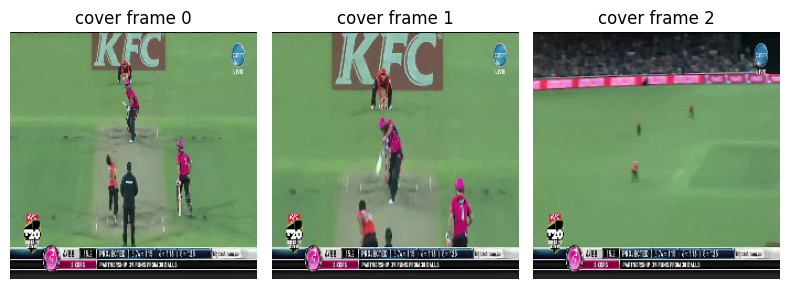

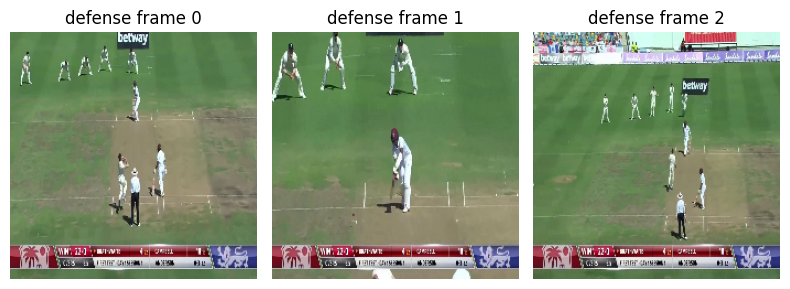

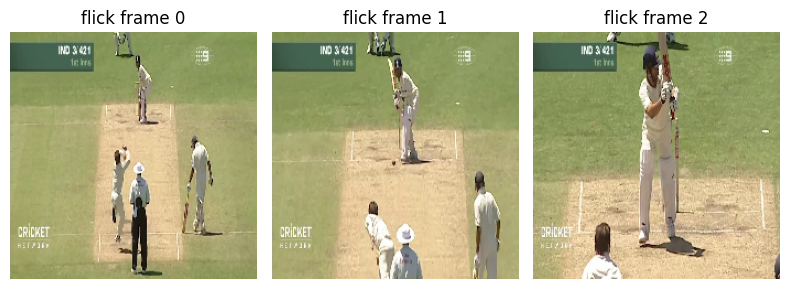

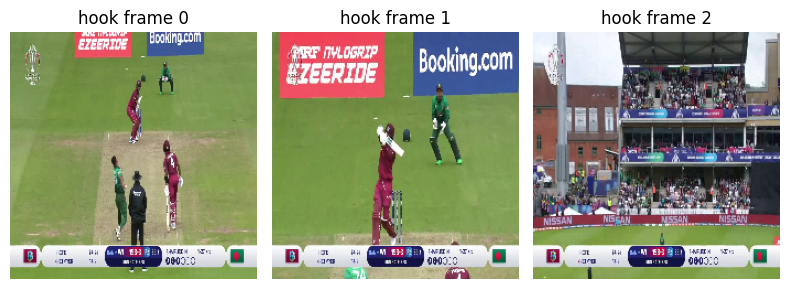

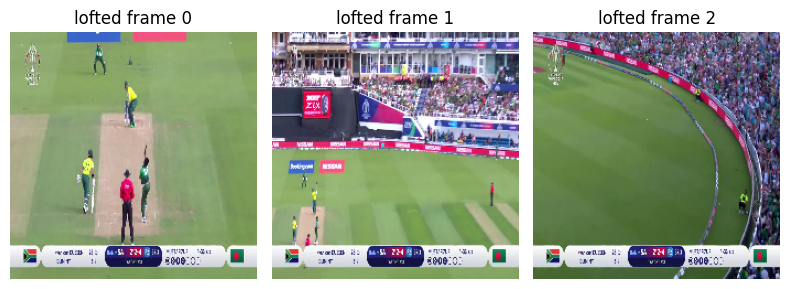

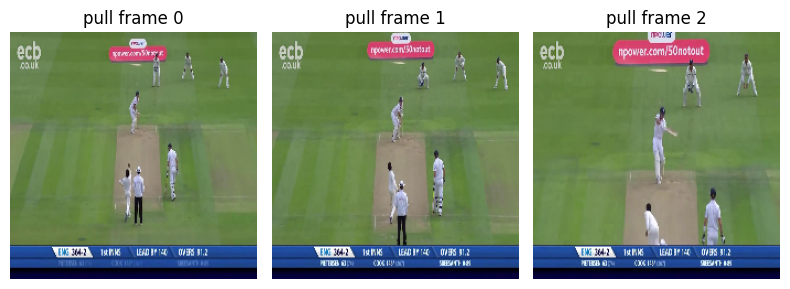

C:\ProgramData\anaconda3\envs\thesisOne\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


,filename,shot_type,length,path,pose_features
0,cover_0001.avi,cover,50,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,cover_0002.avi,cover,52,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,cover_0003.avi,cover,61,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...,"[[0.5008767247200012, 0.7754786014556885, 0.13..."
3,cover_0004.avi,cover,56,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...,"[[0.655778169631958, 0.6391632556915283, -0.09..."
4,cover_0005.avi,cover,61,C:\Users\Maroof Ashraf\Desktop\Thesis\Data\Cri...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [16]:
df = extract_pose_features(df)
df.head()

In [17]:
# Step 1: Train the frame detection model
frame_model = train_model(df, CLASSES_LIST)

C:\Users\Maroof Ashraf\AppData\Local\Temp\ipykernel_14732\1832654113.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_pose = np.array(X_pose)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frames_input (InputLayer)   [(None, 30, 224, 224, 3)]    0         []                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 4)      1024      ['frames_input[0][0]']        
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 30, 111, 111, 4)      0         ['conv_lstm2d[0][0]']         
 D)                                                                                               
                                                                                                  
 time_distributed (TimeDist  (None, 30, 111, 111, 4)      0         ['max_pooling3d[0][0]']   

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
# Step 2: Train the shot detection model
shot_model = train_shot_detection_model(df)

In [ ]:
# Step 3: Use the frame detection model to extract clips from the full-match video
extract_and_classify_clips(frame_model, r'C:\Users\Maroof Ashraf\Desktop\Thesis\HonkongSuperSixesPakvsAusVideo.mp4', 'extracted_clips')

In [ ]:
# Step 4: Classify the extracted clips using the shot detection model
classify_shots(shot_model, 'extracted_clips', 'detected_shots')

In [ ]:
# Step 5: Combine all the detected shot videos into one
combine_videos('detected_shots', 'final_video.mp4')

In [ ]:
# # Main Function
# def main():
#     df = load_dataset(DATASET_PATH)
#     plot_frames(df, DATASET_PATH)
#     df = extract_pose_features(df)

#     # Step 1: Train the frame detection model
#     frame_model = train_model(df, CLASSES_LIST)

#     # Step 2: Use the frame detection model to extract clips from the full match video
#     extract_and_classify_clips(frame_model, 'path/to/full/match/video.avi', 'extracted_clips')

#     # Step 3: Train the shot detection model
#     shot_model = train_shot_detection_model(df)

#     # Step 4: Classify the extracted clips using the shot detection model
#     classify_shots(shot_model, 'extracted_clips', 'detected_shots')

#     # Step 5: Combine all the detected shot videos into one
#     combine_videos('detected_shots', 'final_video.mp4')

In [ ]:
# if __name__ == "__main__":
#     main()